# 5. Predicting goal with multiple classifiers

---

**All features have been extracted, modelled, and stored to parquet files. If these are missing, please re-run the jupyter notebook [9_nhl_data_pipeline.ipynb](9_nhl_data_pipeline.ipynb)**

---

After first feature modelling and evaluation of the model using logistic regression, some new classifiers and some other metrics will be considered.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import time

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file


from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

sns.set()

---
## Preparing data used in the previous sections

In [2]:
# read data stored in a prepared parquet file
df = pd.read_parquet('data/_1_first_dataset.parquet')
df.head()

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot
index,,,,,,,,,,,,
4,2016020045_5,71.0,-9.0,1,54,0,0,0,0,0,0,1
5,2016020045_6,88.0,-5.0,1,56,1,0,0,0,0,1,0
7,2016020045_8,56.0,-7.0,1,69,0,0,0,0,0,0,1
11,2016020045_12,37.0,24.0,1,133,0,0,1,0,0,0,0
16,2016020045_17,57.0,-20.0,1,168,0,0,0,0,0,0,1


In [3]:
# save prepared data
df_data = df.copy()

---
### Using data in the goal prediction

The models are going to be used for different expriments. In order to not the repeat the code, the implementation has been encapsulate in the file *models.py*,
implementing following functions for three different classifiers:

* run_logistic_regression
* run_lightgbm_classifier
* run_kneighbors_classifier

---
In addition to the accuracy score, F1 score and the confusion matrix, the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the AUC-ROC (ared under (ROC) curve) will be evaluated. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ROC space is defined as followed ([source](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:ROC_space-2.png)) :

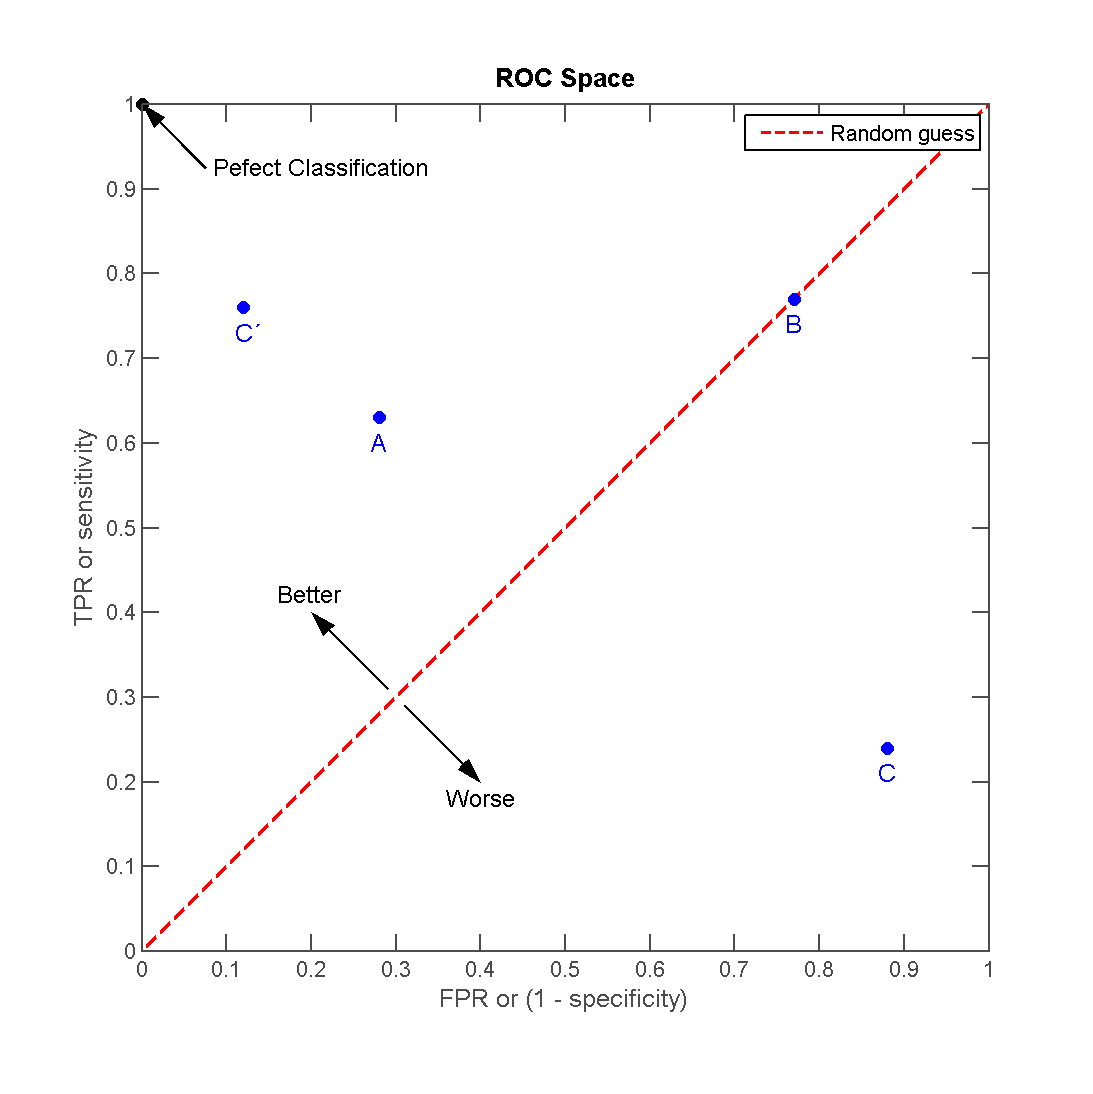

In [4]:
Image(filename='data/images/ROC_space-2.png', width=400, ) #https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:ROC_space-2.png

---
For each of evaluated classifiers, all metrics will be calculated and the confusion matrix and the ROC curce will be plotted:

========== Logistic Regression ==========
Accuracy: 0.9070
F1 Score: 0.0000
AUC-ROC Score: 0.6680
-----------------------------------------
Precision: 0.0000
Recall: 0.0000


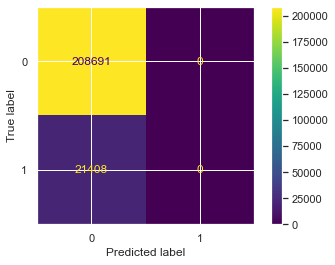

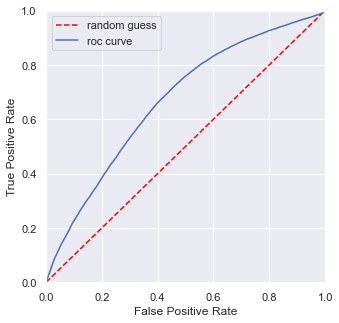

In [5]:
# === Logistic Regression ===
_, lg = run_logistic_regression(df_data);
save_metrics('first_dataset', metrics_lg=lg)

========== LightGBM Classifier ==========
Accuracy: 0.9076
F1 Score: 0.0246
AUC-ROC Score: 0.7504
-----------------------------------------
Precision: 0.6717
Recall: 0.0125


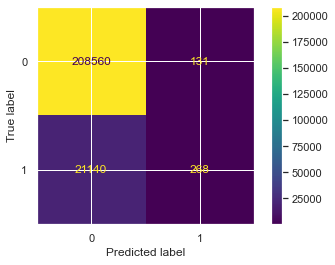

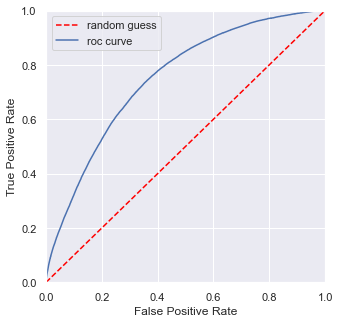

In [6]:
# === LightGBM Classifier ===
_, lgbm = run_lightgbm_classifier(df_data);
save_metrics('first_dataset', metrics_lgbm=lgbm)

========= KNeighbors Classifier =========
Accuracy: 0.9070
F1 Score: 0.0000
AUC-ROC Score: 0.7190
-----------------------------------------
Precision: 0.0000
Recall: 0.0000


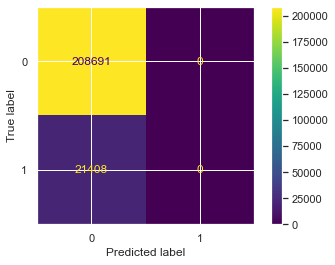

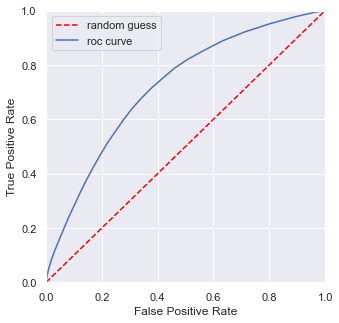

In [7]:
# === KNeighbors Classifier ===
_, knc = run_kneighbors_classifier(df_data);
save_metrics('first_dataset', metrics_knc=knc)

---

This training was done using the unbalanced dataset having too many target goal=0 compared to 1. All classifiers have issues to deal with strongly unbalanced data:

In [8]:
# calculate ratio of 0 vs. 1 target
print(f'Number of 0s in the target: {df_data[df_data.goal == 0].shape[0]}, which is {df_data[df_data.goal == 0].shape[0]/df_data.shape[0]*100:.2f}%')
print(f'Number of 1s in the target: {df_data[df_data.goal == 1].shape[0]}, which is {df_data[df_data.goal == 1].shape[0]/df_data.shape[0]*100:.2f}%')

Number of 0s in the target: 695439, which is 90.67%
Number of 1s in the target: 71557, which is 9.33%


F1 score is Zero or close to Zero. LightGBM is the only classifier able to predict at least some data points as positive although. AUC metrics was ok for all of them, this means it is not sensitive to one sided predictions.

---
#### Trying to use targets weights to solve the imbalanced data issue

---
Comparing for logistic regression:

========== Logistic Regression ==========
Accuracy: 0.9070
F1 Score: 0.0000
AUC-ROC Score: 0.6680
-----------------------------------------
Precision: 0.0000
Recall: 0.0000
========== Logistic Regression ==========
Accuracy: 0.5876
F1 Score: 0.2334
AUC-ROC Score: 0.6654
-----------------------------------------
Precision: 0.1411
Recall: 0.6748


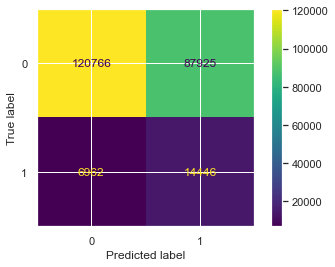

In [9]:
# repeat logistic regressin with and without using the weights

run_logistic_regression(df_data, c_matrix=False, r_curve=False);
_, lg = run_logistic_regression(df_data, balance_weights=True, c_matrix=True, r_curve=False);
save_metrics('weighted', metrics_lg=lg)

The F1 Score is better now but the number of Type I error (false positives) is very high. Even with explicit weights, logistic regression can't handle this problem properly.

---
Comparing for LightGBM:

========== LightGBM Classifier ==========
Accuracy: 0.9076
F1 Score: 0.0246
AUC-ROC Score: 0.7504
-----------------------------------------
Precision: 0.6717
Recall: 0.0125
========== LightGBM Classifier ==========
Accuracy: 0.6510
F1 Score: 0.2821
AUC-ROC Score: 0.7504
-----------------------------------------
Precision: 0.1744
Recall: 0.7371


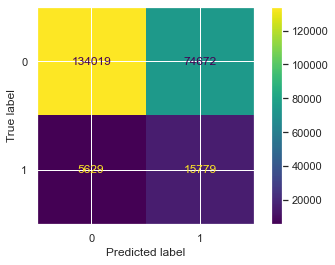

In [10]:
# in order to optimize the LGBM, unbalanced flag will be set
run_lightgbm_classifier(df_data, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data, unbalanced=True, c_matrix=True, r_curve=False);
save_metrics('weighted', metrics_lgbm=lgbm)

Very similar result here. Increase of F1 score but still too many Type I errors (false positives).

---
Small inprovements, not really much, we need to balance the dataset. There are 87187 positive targets in the dataset. If I add a sample of another 87187 negative prediction, we can get the balance and re-train the models again:

### Balance the dataset again - similar like I did in the previous notebook using under-sampling

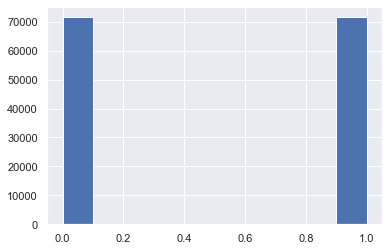

In [11]:
# using a function from utils.py to balance the target
df_balanced = balance_binary_target(df_data, target='goal')
df_balanced.goal.hist();

========== Logistic Regression ==========
Accuracy: 0.6290
F1 Score: 0.6455
AUC-ROC Score: 0.6672
-----------------------------------------
Precision: 0.6165
Recall: 0.6774


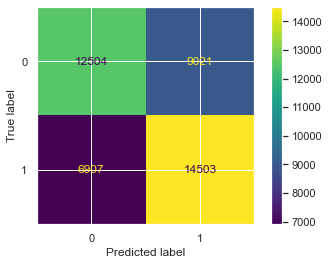

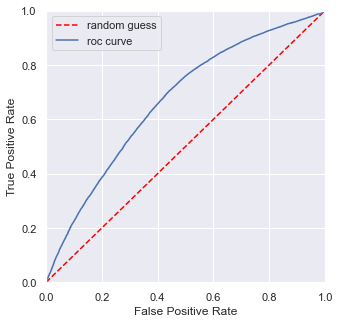

========== LightGBM Classifier ==========
Accuracy: 0.6903
F1 Score: 0.7028
AUC-ROC Score: 0.7521
-----------------------------------------
Precision: 0.6739
Recall: 0.7342


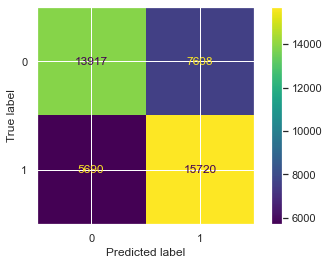

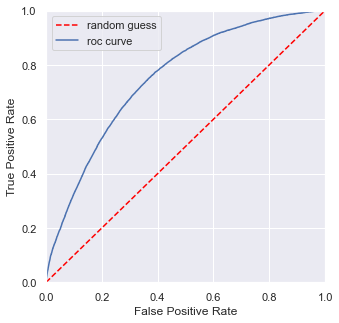

========= KNeighbors Classifier =========
Accuracy: 0.6747
F1 Score: 0.6941
AUC-ROC Score: 0.7266
-----------------------------------------
Precision: 0.6535
Recall: 0.7400


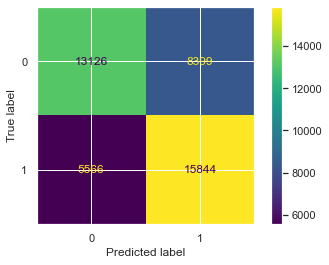

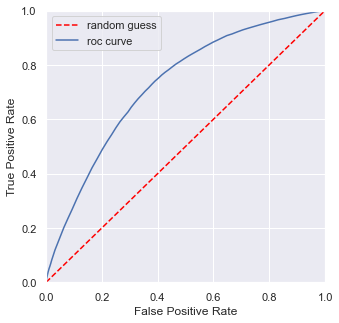

In [12]:
# starting training again
_, lg = run_logistic_regression(df_balanced);
_, lgbm = run_lightgbm_classifier(df_balanced);
_, knc = run_kneighbors_classifier(df_balanced);
save_metrics('balanced', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

Balancing the targets in the dataset boosted the F1 score to values **0.64-0.70** still keeping the AUC value high. 

---

## Use the new features distance modelled in previous sections:

Use dataset with **distance** feature:

In [13]:
# read data stored in a prepared parquet file
df_data_dist = pd.read_parquet('data/_3_with_distance.parquet')
df_data_dist.head()

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance
index,,,,,,,,,,,,,
1336374,2014020633_71,81.0,1.0,1,724,1,0,0,0,0,0,0,19.026298
4579123,2018020644_270,83.0,-2.0,3,740,1,0,0,0,0,0,1,17.117243
2214643,2011020858_283,75.0,-1.0,5,0,1,0,0,1,0,0,0,25.019992
1019494,2015020726_249,84.0,7.0,3,271,1,0,0,1,0,0,0,17.464249
4465973,2018020469_9,31.0,-8.0,1,47,1,0,0,1,0,0,0,69.462220


---
### Re-train and evaluate the models

### With distance

In [14]:
# starting training again
_, lg = run_logistic_regression(df_data_dist, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_dist, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_dist, c_matrix=False, r_curve=False);

save_metrics('with_distance', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.6786
F1 Score: 0.6960
AUC-ROC Score: 0.7303
-----------------------------------------
Precision: 0.6619
Recall: 0.7337
========== LightGBM Classifier ==========
Accuracy: 0.6904
F1 Score: 0.7057
AUC-ROC Score: 0.7490
-----------------------------------------
Precision: 0.6743
Recall: 0.7401
========= KNeighbors Classifier =========
Accuracy: 0.6713
F1 Score: 0.6934
AUC-ROC Score: 0.7225
-----------------------------------------
Precision: 0.6514
Recall: 0.7411


---
Slightly better results

## Use the new features angle 

Similar to the distance feature, let's use angle 

In [15]:
# read data stored in a prepared parquet file
df_data_dist_angle = pd.read_parquet('data/_4_with_distance_angle.parquet')
df_data_dist_angle.head()

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle
index,,,,,,,,,,,,,,
1336374,2014020633_71,81.0,1.0,1,724,1,0,0,0,0,0,0,19.026298,3.012788
4579123,2018020644_270,83.0,-2.0,3,740,1,0,0,0,0,0,1,17.117243,6.709837
2214643,2011020858_283,75.0,-1.0,5,0,1,0,0,1,0,0,0,25.019992,2.290610
1019494,2015020726_249,84.0,7.0,3,271,1,0,0,1,0,0,0,17.464249,23.629378
4465973,2018020469_9,31.0,-8.0,1,47,1,0,0,1,0,0,0,69.462220,6.613460


#### re-train models

In [16]:
# starting training again
_, lg = run_logistic_regression(df_data_dist_angle, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_dist_angle, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_dist_angle, c_matrix=False, r_curve=False);

save_metrics('with_angle', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.6789
F1 Score: 0.6863
AUC-ROC Score: 0.7306
-----------------------------------------
Precision: 0.6728
Recall: 0.7004
========== LightGBM Classifier ==========
Accuracy: 0.6891
F1 Score: 0.7047
AUC-ROC Score: 0.7457
-----------------------------------------
Precision: 0.6729
Recall: 0.7397
========= KNeighbors Classifier =========
Accuracy: 0.6732
F1 Score: 0.6879
AUC-ROC Score: 0.7249
-----------------------------------------
Precision: 0.6602
Recall: 0.7180


There was just a small improvement in the model. The values are more or less same.

---

### Look at the feature importance

========== LightGBM Classifier ==========
Accuracy: 0.6891
F1 Score: 0.7047
AUC-ROC Score: 0.7457
-----------------------------------------
Precision: 0.6729
Recall: 0.7397


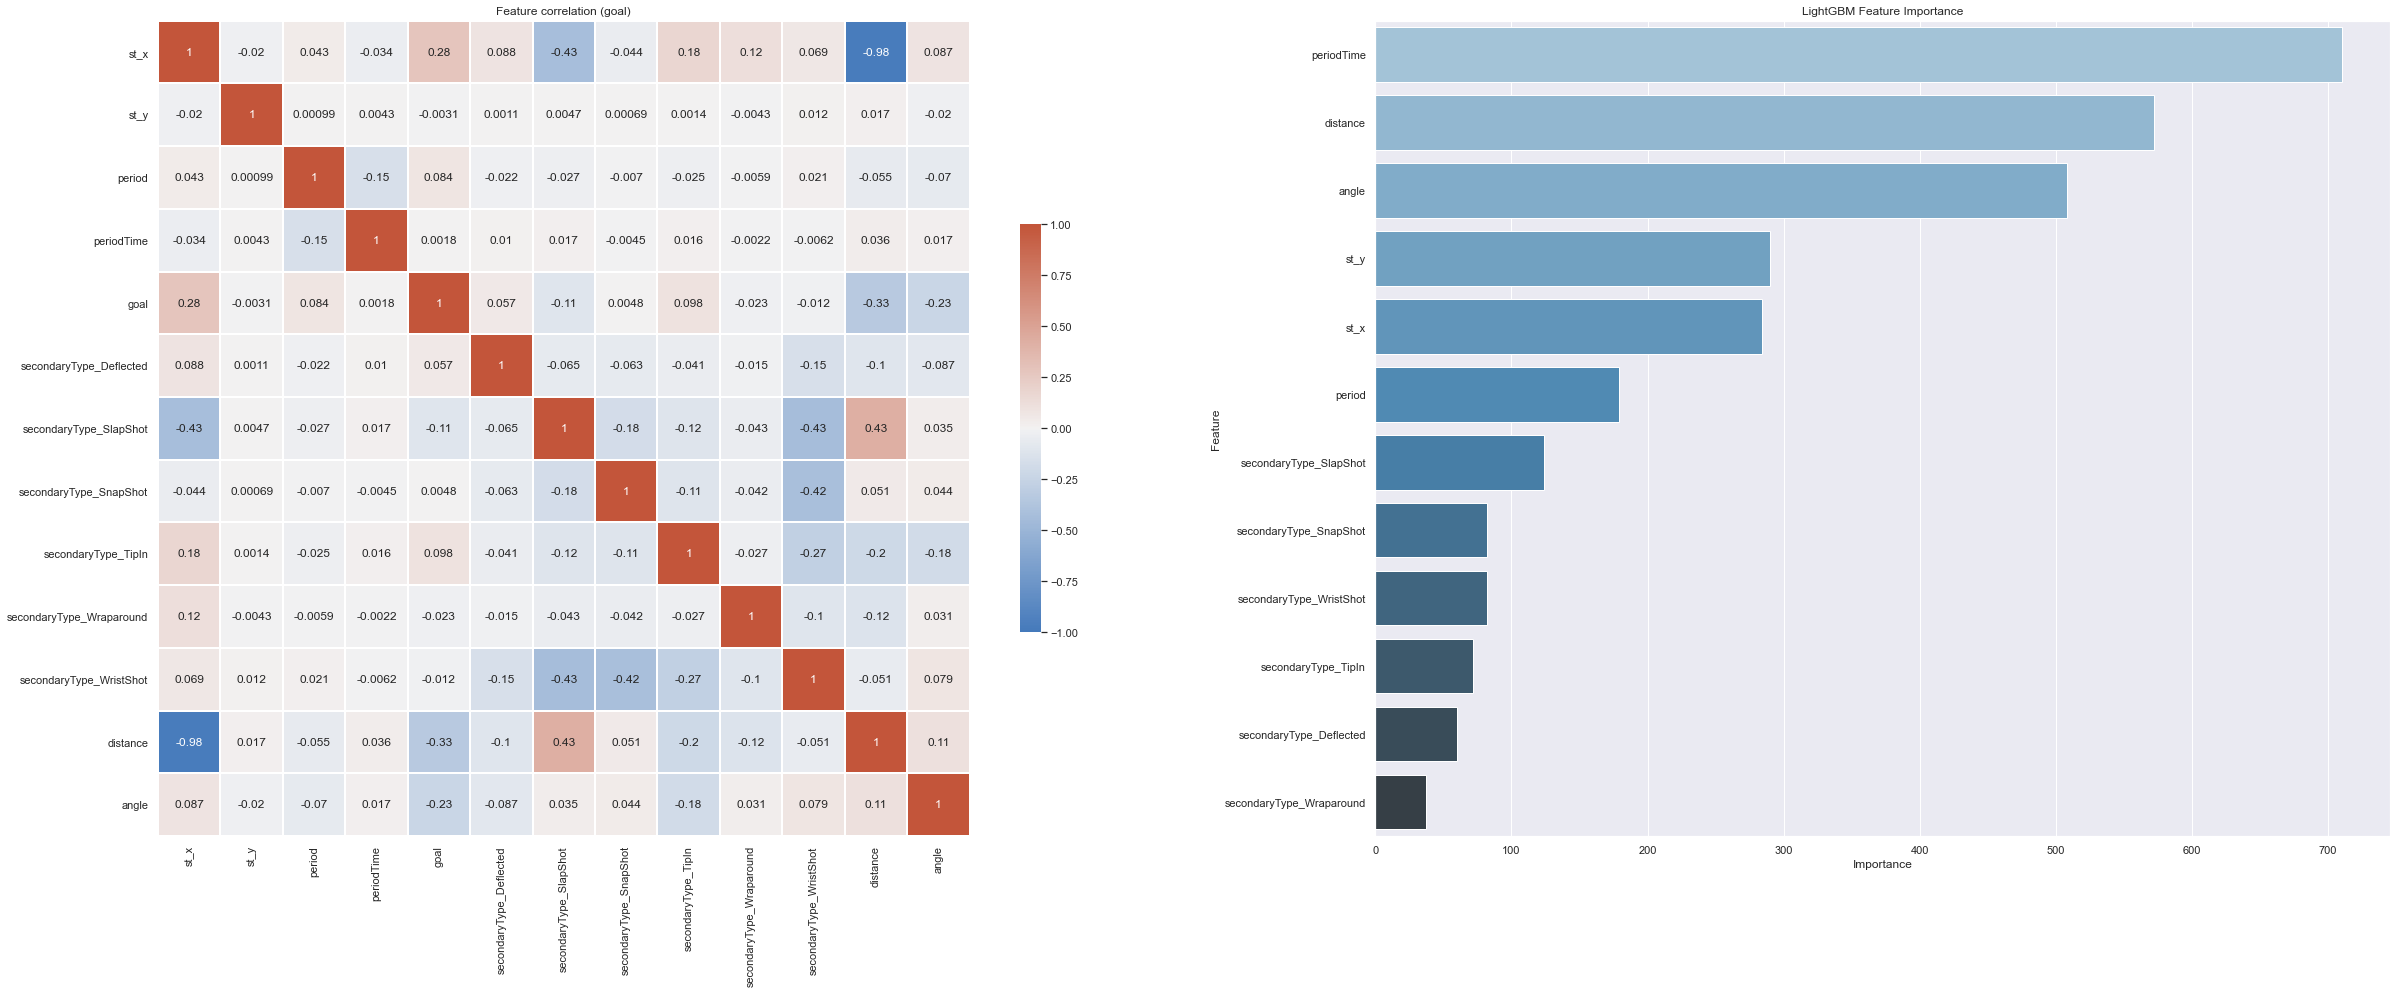

In [17]:
features = df_data_dist_angle.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model, _ = run_lightgbm_classifier(df_data_dist_angle, features=features, target=target, c_matrix=False, r_curve=False);


col='goal'
corr = df_data_dist_angle.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 15))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

---
Feature *angle* is correlated with the *goal*. In the feature importance of the LGBM model, *angle* appears to be the third most important feature. It apparently desreaced the predictive value of other correlated features like *TipIn shot*. All in all, the combination of the features always matter in the model predictions, not particular features alone.

---